## Importing important libraries

In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from transformers import GPT2Tokenizer, TFGPT2Model, GPT2Config
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os

# Hyperparameters
BATCH_SIZE = 16
LEARNING_RATE = 1e-5
EPOCHS = 30
TEST_SIZE = 0.2
RANDOM_STATE = 42
MAX_LEN = 128
BASE_SAVE_PATH = "GPT-3_checkpoints"
FILE_PATH = 'emotion_data_merged_4.csv'


In [2]:
# Load dataset
dataset = pd.read_csv(FILE_PATH)
dataset = dataset.dropna(subset=['emotion']).query("emotion != 'neutral'")
dataset = dataset.drop_duplicates()

# Encode the 'emotion' column to numeric labels
label_encoder = LabelEncoder()
dataset['encoded_emotion'] = label_encoder.fit_transform(dataset['emotion'])

# Prepare prompts
dataset['prompt'] = "This text expresses: " + dataset['sentence']

# Splitting the dataset
X_train, X_val, y_train, y_val = train_test_split(
    dataset['prompt'], dataset['encoded_emotion'], 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=dataset['encoded_emotion']
)


In [3]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# Check if '[PAD]' token exists, else add it to the tokenizer
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Load the GPT-2 model
model = TFGPT2Model.from_pretrained('gpt2')

# IMPORTANT: Resize model embeddings to match the tokenizer's length
# This accommodates any special tokens added to the tokenizer
model.resize_token_embeddings(len(tokenizer))

def encode_prompts(prompts):
    input_ids, attention_masks = [], []
    for prompt in prompts:
        encoded = tokenizer(prompt, padding='max_length', truncation=True, max_length=MAX_LEN, return_tensors="tf")
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0)

# Encode prompts
input_ids_train, attention_masks_train = encode_prompts(X_train.tolist())
input_ids_val, attention_masks_val = encode_prompts(X_val.tolist())


2024-04-03 19:03:34.285963: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-04-03 19:03:34.286262: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6678 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [4]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [5]:
def build_model(num_labels):
    # Load the pre-trained GPT-2 model configuration
    config = GPT2Config.from_pretrained('gpt2', num_labels=num_labels)
    
    # IMPORTANT: Load the GPT-2 model here to ensure it includes any tokenizer adjustments
    gpt2_model = TFGPT2Model.from_pretrained('gpt2', config=config)
    gpt2_model.resize_token_embeddings(len(tokenizer))  # Adjust model's embeddings

    # Define the inputs
    input_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name="attention_mask")
    
    # Get the outputs from the GPT-2 model
    outputs = gpt2_model(input_ids=input_ids, attention_mask=attention_mask)
    sequence_output = outputs.last_hidden_state[:, -1, :]  # Use the last hidden state
    
    # Add a dense layer for classification
    classifier_layer = tf.keras.layers.Dense(num_labels, activation='softmax', name='classifier')(sequence_output)
    
    # Construct the final model
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=classifier_layer)
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


model = build_model(num_labels=len(label_encoder.classes_))


All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [6]:
os.makedirs(BASE_SAVE_PATH, exist_ok=True)
callbacks = [
    ModelCheckpoint(filepath=os.path.join(BASE_SAVE_PATH, "cp-{epoch:04d}.ckpt"), save_weights_only=True, save_best_only=True, monitor='val_loss'),
    EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True, mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)
]


In [9]:
history = model.fit(
    [input_ids_train, attention_masks_train], y_train,
    validation_data=([input_ids_val, attention_masks_val], y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights_dict,
    callbacks=callbacks
)


Epoch 1/30


2024-04-03 19:09:29.155833: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fd02c31da10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-03 19:09:29.155877: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-04-03 19:09:29.166680: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-03 19:09:29.204606: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
I0000 00:00:1712171369.307273  470415 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


23957/23957 [==============================] - 7517s 313ms/step - loss: 0.2855 - accuracy: 0.9087 - val_loss: 0.1187 - val_accuracy: 0.9572 - lr: 1.0000e-05
Epoch 2/30
23957/23957 [==============================] - 4712s 197ms/step - loss: 0.1197 - accuracy: 0.9622 - val_loss: 0.0958 - val_accuracy: 0.9660 - lr: 1.0000e-05
Epoch 3/30
23957/23957 [==============================] - 3165s 132ms/step - loss: 0.0951 - accuracy: 0.9687 - val_loss: 0.0892 - val_accuracy: 0.9684 - lr: 1.0000e-05
Epoch 4/30
23957/23957 [==============================] - 3158s 132ms/step - loss: 0.0773 - accuracy: 0.9733 - val_loss: 0.0944 - val_accuracy: 0.9680 - lr: 1.0000e-05
Epoch 5/30
23957/23957 [==============================] - 3161s 132ms/step - loss: 0.0618 - accuracy: 0.9776 - val_loss: 0.0917 - val_accuracy: 0.9700 - lr: 1.0000e-05
Epoch 6/30
23957/23957 [==============================] - 3163s 132ms/step - loss: 0.0434 - accuracy: 0.9829 - val_loss: 0.0951 - val_accuracy: 0.9720 - lr: 3.0000e-06


In [12]:
import joblib

# Define the base path for saving
base_save_path = "GPT-2_v1-Copy1"

# Specify the paths for the model, tokenizer, and label encoder
model_save_path = f"{base_save_path}/model"
tokenizer_save_path = f"{base_save_path}/tokenizer"
label_encoder_save_path = f"{base_save_path}/label_encoder.joblib"

# Assuming `model` is your TFRobertaForSequenceClassification model,
# `tokenizer` is your RobertaTokenizer, and `label_encoder` is your LabelEncoder instance

# Save the model
model.save(model_save_path)

# Save the tokenizer
tokenizer.save_pretrained(tokenizer_save_path)

# Save the label encoder
joblib.dump(label_encoder, label_encoder_save_path)

INFO: Assets written to: GPT-2_v1-Copy1/model/assets


['GPT-2_v1-Copy1/label_encoder.joblib']

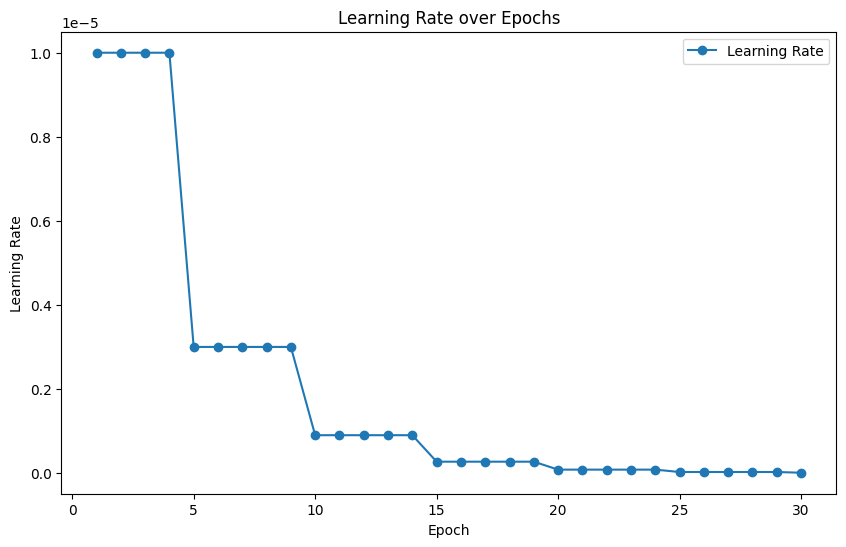

In [13]:
import matplotlib.pyplot as plt

# Example data
epochs = range(1, EPOCHS + 1)
learning_rates = [LEARNING_RATE * (0.3 ** (epoch // 5)) for epoch in epochs]  # Example decay

plt.figure(figsize=(10, 6))
plt.plot(epochs, learning_rates, 'o-', label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Epochs')
plt.legend()
plt.show()


2995/2995 [==============================] - 233s 78ms/step


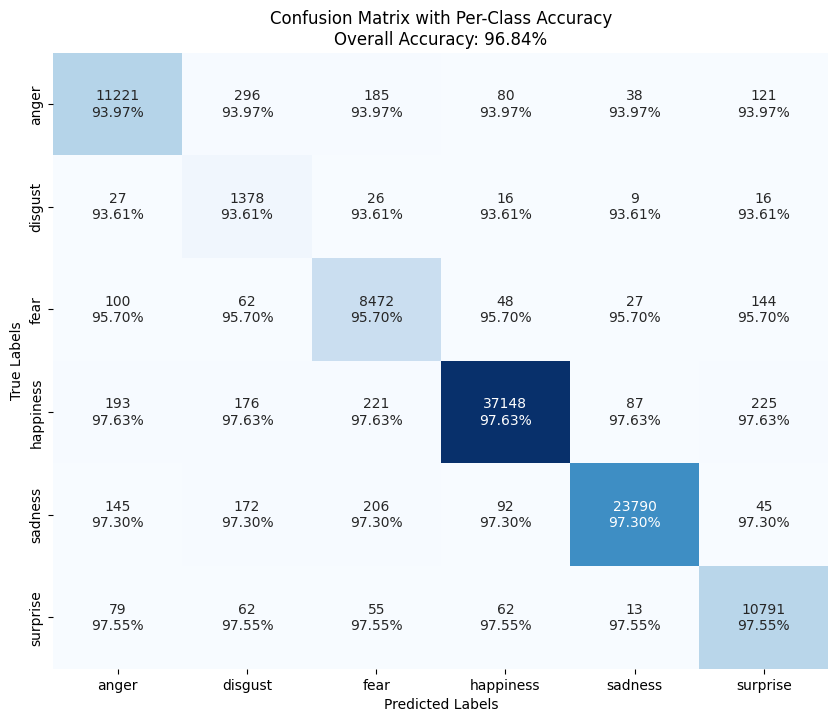

In [25]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming `input_ids_val` and `attention_masks_val` are your validation set inputs,
# and `model` is your trained model
predictions = model.predict([input_ids_val, attention_masks_val])
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the confusion matrix and overall accuracy
cm = confusion_matrix(y_val, predicted_labels)
overall_accuracy = accuracy_score(y_val, predicted_labels) * 100

# Calculate per-class accuracy
per_class_accuracy = np.diag(cm) / np.sum(cm, axis=1) * 100

# Prepare annotations with count and accuracy
annotations = [[f"{cm[i, j]}\n{per_class_accuracy[i]:.2f}%" for j in range(cm.shape[1])]
               for i in range(cm.shape[0])]

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=annotations, fmt='', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix with Per-Class Accuracy\nOverall Accuracy: {overall_accuracy:.2f}%')
plt.show()


In [15]:
report = classification_report(y_val, predicted_labels, target_names=label_encoder.classes_)
print(report)


              precision    recall  f1-score   support

       anger       0.95      0.94      0.95     11941
     disgust       0.64      0.94      0.76      1472
        fear       0.92      0.96      0.94      8853
   happiness       0.99      0.98      0.98     38050
     sadness       0.99      0.97      0.98     24450
    surprise       0.95      0.98      0.96     11062

    accuracy                           0.97     95828
   macro avg       0.91      0.96      0.93     95828
weighted avg       0.97      0.97      0.97     95828



In [20]:
import pandas as pd
import tensorflow as tf
import numpy as np

# Load the test dataset
test_df = pd.read_csv('test (1).csv', sep='\t')  # Adjust filename as necessary

# Replace the exclamation point at the end of each sentence with a dot
test_df['sentence'] = test_df['sentence'].str.replace(r'!\s*$', '.', regex=True)

# Prepare prompts for the test dataset
test_prompts = "This text expresses: " + test_df['sentence']


In [21]:
def encode_prompts(prompts, tokenizer, max_len=128):
    input_ids, attention_masks = [], []
    for prompt in prompts:
        encoded = tokenizer.encode_plus(
            prompt,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='tf',
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0)

# Encode the test prompts
test_input_ids, test_attention_masks = encode_prompts(test_prompts, tokenizer, MAX_LEN)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [22]:
# Assuming `model` is your trained GPT-based model
predictions = model.predict([test_input_ids, test_attention_masks])
predicted_labels = np.argmax(predictions, axis=1)


45/45 [==============================] - 3s 77ms/step


In [23]:
# Assuming `label_encoder` is already defined and fitted to your training labels
predicted_emotions = label_encoder.inverse_transform(predicted_labels)


In [24]:
# Prepare the submission DataFrame
submission_df = pd.DataFrame({
    'id': test_df['id'],  # Assuming there's an 'id' column in your test dataset
    'emotion': predicted_emotions
})

# Save the submission file
submission_file_name = 'GPT_emotion_predictions.csv'
submission_df.to_csv(submission_file_name, index=False, sep=',')
print(f"Submission file '{submission_file_name}' saved successfully.")


Submission file 'GPT_emotion_predictions.csv' saved successfully.
